In [2]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
# sk-1feb7ffcf87f43a2a3feb12cc8349348
_set_env("DEEPSEEK_API_KEY")

# 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
_set_env("TAVILY_API_KEY")



class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearch(max_results=2)
tools = [tool]
llm = init_chat_model("deepseek-chat")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [3]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [4]:
graph = graph_builder.compile(checkpointer=memory)

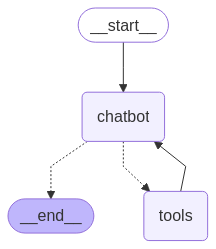

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
config = {"configurable": {"thread_id": "1"}}

用stream/invoke方法调用我们的图时，config作为第二个参数传递

In [7]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! It's great to meet you. How can I assist you today?


下面再次对话，传入相同的config，即线程id，调用之前关于我的名字的记忆。

In [13]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, Will! I’ll remember your name for the rest of our conversation. What can I do for you?


snapshot对一个图取快照，要传入config来确定取的是什么记忆。

In [20]:
snapshot = graph.get_state(config = config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='cb626bb2-63b7-4935-8728-52b0dedc4a45'), AIMessage(content="Hi Will! It's great to meet you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1246, 'total_tokens': 1263, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1216}, 'prompt_cache_hit_tokens': 1216, 'prompt_cache_miss_tokens': 30}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0425fp8', 'id': '7a4267a0-3e99-453c-a832-54010e3e1b9e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--bbd57eae-a813-43fb-9e94-baeaa6a90b7c-0', usage_metadata={'input_tokens': 1246, 'output_tokens': 17, 'total_tokens': 1263, 'input_token_details': {'cache_read': 1216}, 'output_token_details': {}}), HumanMessage(content='Remembe

因为上次已经完成了整个图（走到end了），所以下个节点是空

In [17]:
snapshot.next


()